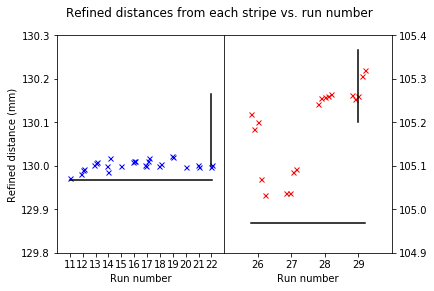

In [5]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

# original root = "/reg/d/psdm/cxi/cxi78513/res/brewster/paper_2017/plots"
root = "data/figure7"
files = [os.path.join(root, "chunksbyrun_t016_dists_rg1_cumm.txt"),
         os.path.join(root, "chunksbyrun_t016_dists_rg2_cumm.txt")]

write_pdf = False

#t16 using cumulative distance (d+q+s)
d1 = 129.9672222
d2 = 104.9687474
yscales = (129.8,130.3),(104.9,105.4) # t16 cumm dist

#t16 using cumulative distance (d+q+s)
bar1 = 0.16545816
bar2 = 0.165460107

if write_pdf:
  f, axes = plt.subplots(1, 2, figsize=(4.42/2.54, 3.32/2.54))
else:
  f, axes = plt.subplots(1, 2)

for i, (ax, filename, yscale) in enumerate(zip(axes, files, yscales)):
  data = {}
  for line in open(filename):
    run, dist = line.split()
    run = int(run.lstrip('r'))
    dist = -float(dist)
    if run in data:
      data[run].append(dist)
    else:
      data[run] = [dist]

  x = []; y = []
  for run, dists in data.iteritems():
    increment = 0.1
    start = run - ((len(dists)-1)/2 * increment)
    for k in xrange(len(dists)):
      x.append(start + (k*increment))
    #x.extend([run]*len(dists))
    y.extend(dists)

  if write_pdf:
    ax.plot(x, y,'x',markersize=2,color=['blue','red'][i],linewidth=0.5)
  else:
    ax.plot(x, y,'x',markersize=5,color=['blue','red'][i],linewidth=0.5)

  ax.plot(x, [[d1,d2][i]]*len(y),'-',color='black')

  _x = [22,29][i]
  _y = [130, 105.2][i]
  ax.plot([_x, _x],[_y, _y+[bar1,bar2][i]], '-', color='black')

  ax.get_yaxis().get_major_formatter().set_useOffset(False)
  if not write_pdf:
    ax.set_xlabel("Run number")
    if i == 0:
      ax.set_ylabel("Refined distance (mm)")
  else:
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.get_xaxis().tick_bottom()
  ax.set_ylim(yscale)
  if i == 0:
    ax.set_xlim(10, 23)
    ax.yaxis.tick_left()
  else:
    ax.set_xlim(25, 30)
    ax.yaxis.tick_right()
  ax.set_xticks([r for r in sorted(data.keys())])
plt.subplots_adjust(wspace=0, hspace=0)
if not write_pdf:
  plt.suptitle("Refined distances from each stripe vs. run number")

if write_pdf:
  pp = PdfPages('striped_distances.pdf')
  for i in plt.get_fignums():
    pp.savefig(plt.figure(i))
  pp.close()
else:
  plt.show()

In [8]:
import glob
#files = glob.glob("/reg/data/ana14/cxi/cxi78513/scratch/brewster/paper_2017/striping/by_run_t016_mr_ch/*/*/int*/*reint*.json")
files = glob.glob(root + "/by_run_t016_mr_ch/*/*/int*/*reint*.json")


In [9]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import os, sys, math
from cctbx.crystal import symmetry
from libtbx import easy_pickle
from dxtbx.model.experiment_list import ExperimentListFactory
from dials.array_family import flex
from libtbx import easy_mp

write_pdf=False

cs = symmetry(unit_cell = (93.3, 93.3, 130.9, 90, 90, 120), space_group = "P 61 2 2")
mset = cs.build_miller_set(anomalous_flag=False, d_min=1.7)
n_bins = 20
binner = mset.setup_binner(n_bins=n_bins)

centers = flex.double()
for binid in binner.range_used():
  d_max, d_min = binner.bin_d_range(binid)
  centers.append(d_min+((d_max-d_min)/2))

def get_mean_isigi(experiments, reflections):
  all_d = flex.double()
  sorted_refls = flex.reflection_table()
  for expt_id, experiment in enumerate(experiments):
    refls = reflections.select(reflections['id'] == expt_id)
    all_d.extend(experiment.crystal.get_unit_cell().d(refls['miller_index']))
    sorted_refls.extend(refls)
  reflections = sorted_refls

  isigi = flex.double()
  for binid in binner.range_used():
    d_max, d_min = binner.bin_d_range(binid)
    subrefls = reflections.select((all_d < d_max) & (all_d >= d_min))
    if len(subrefls) == 0:
      isigi.append(0)
    else:
      isigi.append(flex.mean(subrefls['intensity.sum.value']/flex.sqrt(subrefls['intensity.sum.variance'])))
  return isigi

colors = ['blue','red']
color_offset = 12 # rg 13-14

plot_option = ["difference", "percentage","absolute"][1]

def do_work(filename):
  rg = int(os.path.basename(filename).split('_')[1].lstrip('rg'))
  color = colors[rg-1-color_offset]
  #color = colors[0]
  print filename, color
  reint_expts = ExperimentListFactory.from_json_file(filename, check_format=False)
  orig_jsons_path = os.path.join(os.path.dirname(filename), "orig", os.path.splitext(os.path.basename(filename))[0] + "_orig.json")
  print orig_jsons_path, os.path.exists(orig_jsons_path)
  #if not os.path.exists(orig_jsons_path): return None, None
  orig_expts = ExperimentListFactory.from_json_file(orig_jsons_path, check_format=False)
  reint_pickle_path = os.path.join(os.path.dirname(filename), os.path.splitext(os.path.basename(filename))[0].replace("experiments", "reflections") + ".pickle")
  print reint_pickle_path, os.path.exists(reint_pickle_path)
  #if not os.path.exists(reint_pickle_path): return None, None
  reint_refls = easy_pickle.load(reint_pickle_path)
  orig_refls = easy_pickle.load(os.path.join(os.path.dirname(filename), "orig", os.path.splitext(os.path.basename(reint_pickle_path))[0] + "_orig.pickle"))

  orig_isigi = get_mean_isigi(orig_expts, orig_refls)
  reint_isigi = get_mean_isigi(reint_expts, reint_refls)
  if plot_option == "difference":
    return color, reint_isigi-orig_isigi
  if plot_option == "percentage":
    return color, 100*reint_isigi/orig_isigi
  if plot_option == "absolute":
    return color, orig_isigi

results = easy_mp.parallel_map(func=do_work, iterable=files, processes=32)



data/figure7/by_run_t016_mr_ch/r0011/combine_experiments_t016/intermediates/t016_rg013_chunk000_reintegrated_experiments.json blue
data/figure7/by_run_t016_mr_ch/r0012/combine_experiments_t016/intermediates/t016_rg013_chunk000_reintegrated_experiments.json blue
data/figure7/by_run_t016_mr_ch/r0012/combine_experiments_t016/intermediates/t016_rg013_chunk001_reintegrated_experiments.json blue
data/figure7/by_run_t016_mr_ch/r0012/combine_experiments_t016/intermediates/t016_rg013_chunk002_reintegrated_experiments.json blue
data/figure7/by_run_t016_mr_ch/r0013/combine_experiments_t016/intermediates/t016_rg013_chunk000_reintegrated_experiments.json blue
data/figure7/by_run_t016_mr_ch/r0013/combine_experiments_t016/intermediates/t016_rg013_chunk001_reintegrated_experiments.json blue
data/figure7/by_run_t016_mr_ch/r0013/combine_experiments_t016/intermediates/t016_rg013_chunk002_reintegrated_experiments.json blue
data/figure7/by_run_t016_mr_ch/r0014/combine_experiments_t016/intermediates/t016_rg

data/figure7/by_run_t016_mr_ch/r0016/combine_experiments_t016/intermediates/orig/t016_rg013_chunk001_reintegrated_experiments_orig.json True
data/figure7/by_run_t016_mr_ch/r0022/combine_experiments_t016/intermediates/t016_rg013_chunk001_reintegrated_reflections.pickle True
data/figure7/by_run_t016_mr_ch/r0018/combine_experiments_t016/intermediates/orig/t016_rg013_chunk001_reintegrated_experiments_orig.json True
data/figure7/by_run_t016_mr_ch/r0014/combine_experiments_t016/intermediates/orig/t016_rg013_chunk001_reintegrated_experiments_orig.json True
data/figure7/by_run_t016_mr_ch/r0022/combine_experiments_t016/intermediates/t016_rg013_chunk000_reintegrated_reflections.pickle True
data/figure7/by_run_t016_mr_ch/r0021/combine_experiments_t016/intermediates/t016_rg013_chunk000_reintegrated_reflections.pickle True
data/figure7/by_run_t016_mr_ch/r0021/combine_experiments_t016/intermediates/t016_rg013_chunk001_reintegrated_reflections.pickle True
data/figure7/by_run_t016_mr_ch/r0019/combine_

data/figure7/by_run_t016_mr_ch/r0029/combine_experiments_t016/intermediates/t016_rg014_chunk002_reintegrated_experiments.json red
data/figure7/by_run_t016_mr_ch/r0028/combine_experiments_t016/intermediates/orig/t016_rg014_chunk004_reintegrated_experiments_orig.json True
data/figure7/by_run_t016_mr_ch/r0029/combine_experiments_t016/intermediates/t016_rg014_chunk003_reintegrated_experiments.json red
data/figure7/by_run_t016_mr_ch/r0029/combine_experiments_t016/intermediates/orig/t016_rg014_chunk001_reintegrated_experiments_orig.json True
data/figure7/by_run_t016_mr_ch/r0029/combine_experiments_t016/intermediates/orig/t016_rg014_chunk000_reintegrated_experiments_orig.json True
data/figure7/by_run_t016_mr_ch/r0029/combine_experiments_t016/intermediates/t016_rg014_chunk004_reintegrated_experiments.json red
data/figure7/by_run_t016_mr_ch/r0028/combine_experiments_t016/intermediates/t016_rg014_chunk004_reintegrated_reflections.pickle True
data/figure7/by_run_t016_mr_ch/r0029/combine_experimen

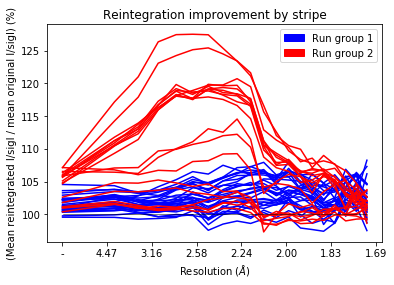

In [10]:
if write_pdf:
  fig, ax = plt.subplots(figsize=(4.42/2.54, 3.32/2.54))
else:
  fig, ax = plt.subplots()
for color, data in results:
  if color is None or data is None: continue
  plt.plot(1/(centers**2), data, '-', c=color)

def resolution(x, pos):
  if x <= 0:
    return '-'
  return "%.2f"%(1/math.sqrt(x))
  #return ""
formatter = FuncFormatter(resolution)
ax.xaxis.set_major_formatter(formatter)
if plot_option == "difference":
  plt.plot([1/(centers[0]**2), 1/(centers[-1]**2)], [0, 0], '-', c='black',linewidth=0.5)
if plot_option == "percentage":
  plt.plot([1/(centers[0]**2), 1/(centers[-1]**2)], [100, 100], '-', c='black',linewidth=0.5)
if not write_pdf:
  plt.title("Reintegration improvement by stripe")
  plt.xlabel(r"Resolution ($\AA$)")
  if plot_option == "difference":
    plt.ylabel("Mean reintegrated I/sigI - mean original I/sigI")
  if plot_option == "percentage":
    plt.ylabel("(Mean reintegrated I/sigI / mean original I/sigI) (%)")

  plt.legend(handles=[mpatches.Patch(color=colors[i], label='Run group %d'%(i+1)) for i in xrange(len(colors))])
else:
  ax.xaxis.tick_bottom()
  ax.yaxis.tick_left()
  ax.yaxis.set_ticklabels([])

#ax.set_ylim(-1, 4)

if write_pdf:
  pp = PdfPages('striped_isigi.pdf')
  for i in plt.get_fignums():
    pp.savefig(plt.figure(i))
  pp.close()
else:
  plt.show()